# Определение стоимости автомобилей

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from catboost import CatBoostClassifier
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.dummy import DummyRegressor

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/datasets/autos.csv')
display(df.head())
print(df.info(),df.isna().sum())
#print(df.sample(random_state = 123))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB
None DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
P

Видим пропуски в столбцах VehicleType, Gearbox, Model, FuelType, NotRepaired.

In [4]:
for i in df.columns:
    print('-------'*5,i,'-------'*5)
    print(df[i].describe())

----------------------------------- DateCrawled -----------------------------------
count                  354369
unique                 271174
top       2016-03-24 14:49:47
freq                        7
Name: DateCrawled, dtype: object
----------------------------------- Price -----------------------------------
count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64
----------------------------------- VehicleType -----------------------------------
count     316879
unique         8
top        sedan
freq       91457
Name: VehicleType, dtype: object
----------------------------------- RegistrationYear -----------------------------------
count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: Registrat

В столбцах RegistrationYear и Power есть некорректные значения. 
В столбце RegistrationMonth присутствует 0. Так же есть объявления с ценой автомобиля 0.

### Предобработка данных

Столбцы DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode, LastSeen не являются значимыми. 

In [5]:
new_df = df[['VehicleType', 
                         'Gearbox', 
                         'Power',
                         'Kilometer',
                         'FuelType',
                         'Brand',
                         'NotRepaired',
                         'RegistrationYear',
                         'Model',
                         'Price']]

Проверим сколько нулей в столбце с ценой.

In [6]:
print(len(df.query('Price == 0')))
print(len(df.query('Price == 0'))/ len(df))

10772
0.030397692800442477


Всего пропусков 10772 в столбце Price, что составляет 3% от общей выборки, удалим эти значения.

In [7]:
new_df = new_df.query('Price > 0')
#print(len(new_df.query('Price <= 100')))

Посмотрим на распределение цены на гистограме.

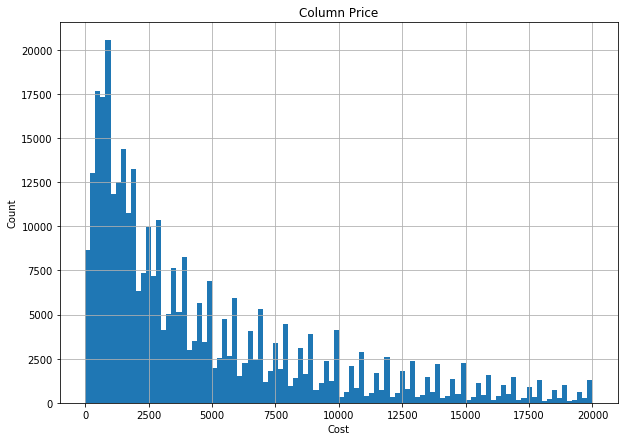

count    343597.000000
mean       4555.121974
std        4515.058553
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64


In [8]:
new_df['Price'].hist(bins = 100, figsize = (10,7))
plt.title('Column Price')
plt.xlabel('Cost')
plt.ylabel('Count')
plt.show()
print(new_df['Price'].describe())

Предположим, что минимальная цена автомобиля равна 400 евро, а максимальная 10000 евро.

In [9]:
#print(len(new_df.query('Price <= 150')))
#print(len(new_df.query('Price <= 400')))

In [10]:
new_df = new_df.query('150 < Price < 12500')
#new_df['Price'].hist(bins = 100, figsize = (10,7))
#plt.show()
print((len(df) - len(new_df))/len(df))

0.12909707113206856


Удалили 12% данных

Разберемся с выбросами в столбце RegistrationYear. Максимальный год выпуска равен 9999, а минимальный 1000.

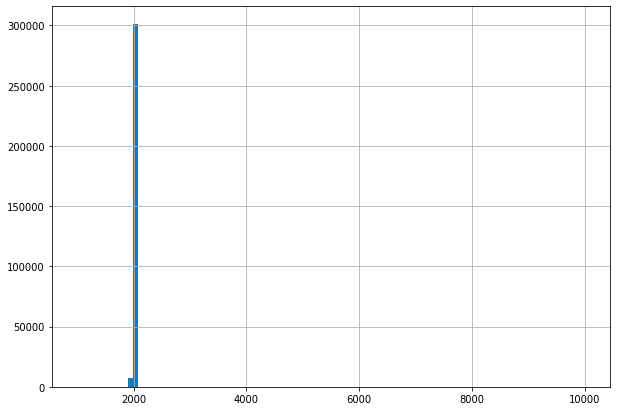

In [11]:
new_df['RegistrationYear'].hist(bins = 100, figsize = (10,7))
plt.show()


In [12]:
date = pd.to_datetime(df['DateCrawled'])
date.max()

Timestamp('2016-04-07 14:36:58')

В 2016 была скачана последняя анкета из базы. Этот год будет считать максимальным годом выпуска. Первый автомобиль с автомобиль с двигателем внутреннего сгорания был построен в 1885, этот год будем считать минимальным.

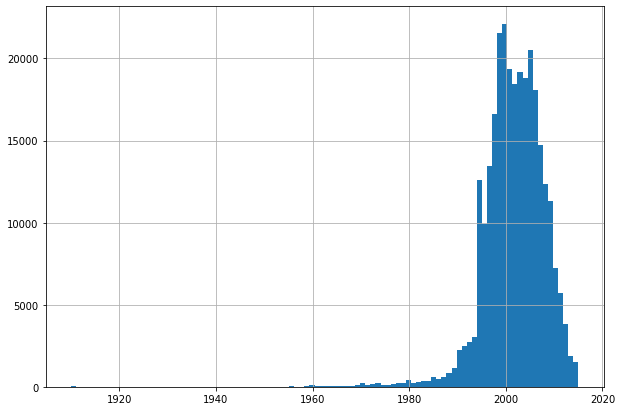

In [13]:
new_df = new_df.query('1885 < RegistrationYear < 2016')
new_df['RegistrationYear'].hist(bins = 100, figsize = (10,7))
plt.show()

Удалим записи об автомобилях до 1960 года.

In [14]:
new_df = new_df.query('1960 < RegistrationYear < 2016')
print((len(df) - len(new_df))/len(df))

0.19062897713964821


Теперь выбросы в столбце Power. Минмальное значение равно 0, а максимальное 20000.
Сразу отбросим значения больше 1500

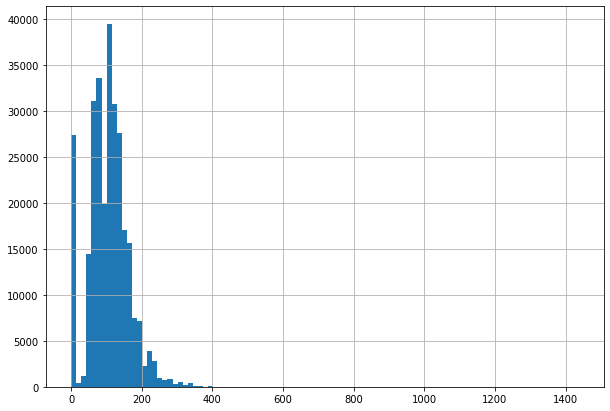

In [15]:
new_df = new_df.query('Power < 1500')
new_df['Power'].hist(bins = 100, figsize = (10,7))
plt.show()

0.26893718129971866


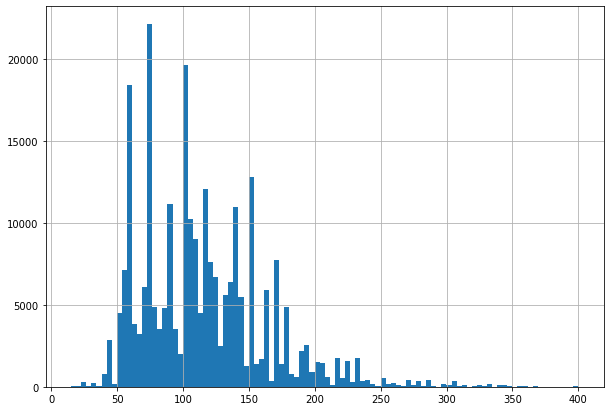

In [16]:
new_df = new_df.query('15 <= Power < 401')
new_df['Power'].hist(bins = 100, figsize = (10,7))
print((len(df) - len(new_df))/len(df))

Пропуски в Gearbox заменим на значение manual, в NotRepaired на yes, model на unknown. Оставшиеся пропуски в столбцах VehicleType и FuelType удалим.

In [17]:
print((len(df) - len(new_df))/len(df))
print(new_df['Gearbox'].value_counts(), new_df['NotRepaired'].value_counts())

0.26893718129971866
manual    208651
auto       45923
Name: Gearbox, dtype: int64 no     195228
yes     26366
Name: NotRepaired, dtype: int64


In [18]:
new_df.fillna({'Gearbox':'manual', 
                           'NotRepaired':'yes',
                           'Model':'unknown'},
                          inplace=True)
new_df = new_df.dropna()

Столбцы 'VehicleType','FuelType','Brand','Model', 'Gearbox' и ''NotRepaired содержат категориальные переменные. Необходимо их закодировать.
Стобцы 'Gearbox' и ''NotRepaired содержат всего два значения, можем их просто заменить на 0 и 1.

In [19]:
coding = {'Gearbox' : {"manual": 1, 'auto': 0},
         'NotRepaired': {'yes': 1, 'no': 0}}
new_df = new_df.replace(coding)
#display(new_df.head())

In [20]:
new_df = new_df.rename(columns={'Gearbox': 'ManualGearbox'})
#display(new_df.head())

In [21]:
encoder = OrdinalEncoder()
new_df["VehicleType_code"] = encoder.fit_transform(new_df[["VehicleType"]])
new_df["FuelType_code"] = encoder.fit_transform(new_df[["FuelType"]])
new_df["Brand_code"] = encoder.fit_transform(new_df[["Brand"]])
new_df["Model_code"] = encoder.fit_transform(new_df[["Model"]])
new_df["VehicleType_code"] = new_df["VehicleType_code"].astype('int')
new_df["FuelType_code"] = new_df["FuelType_code"].astype('int')
new_df["Brand_code"] = new_df["Brand_code"].astype('int')
new_df["Model_code"] = new_df["Model_code"].astype('int')
oe_df = new_df.drop(["VehicleType","FuelType","Brand","Model"], axis = 1)
features = oe_df.drop('Price', axis = 1)
target = oe_df['Price']
display(len(features),len(new_df))
print((len(df) - len(new_df))/len(df))

244734

244734

0.3093808995707864


In [22]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=421)

## Обучение моделей

### CatBoost


In [23]:
%%time

regressor = CatBoostRegressor(learning_rate=0.5,
                              iterations = 200,
                              random_state=19072020, 
                              verbose=False, 
                              cat_features=['VehicleType_code','FuelType_code','Brand_code','Model_code']) 

cv_RMSE_CBR = (cross_val_score(regressor,
                                features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMS =', cv_RMSE_CBR)

RMS = 1215.3678897720288
CPU times: user 6min 1s, sys: 50.9 s, total: 6min 52s
Wall time: 9min 44s


In [24]:
%%time

regressor.fit(features_train, target_train)
regressor_pred = regressor.predict(features_test)
print('RMSE test = ',mean_squared_error(target_test, regressor_pred)**(.5))

RMSE test =  1212.1931215766895
CPU times: user 1min 29s, sys: 14.1 s, total: 1min 43s
Wall time: 3min 8s


### Linear Regression

In [25]:
%%time

LR_model = LinearRegression()
cv_RMSE_LR = (cross_val_score(LR_model, 
                             features_train, 
                             target_train, 
                             cv=5, scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE =', cv_RMSE_LR)


RMSE = 2052.8656176861064
CPU times: user 494 ms, sys: 420 ms, total: 914 ms
Wall time: 2.7 s


In [26]:
%%time
LR_model.fit(features_train,target_train)
lr_pred = LR_model.predict(features_test)
print('RMSE test = ',mean_squared_error(target_test, lr_pred)**(.5))

RMSE test =  2048.4514064013024
CPU times: user 76.5 ms, sys: 41 ms, total: 117 ms
Wall time: 496 ms


### LightGBM

In [27]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[123]}]


clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print(clf.best_params_)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5
print('RMSE = ',cv_RMSE_LGBMR)

{'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 123}
1262.331331 for {'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 123}
1210.816752 for {'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 123}
1192.829086 for {'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 123}
1226.625139 for {'learning_rate': 0.3, 'num_leaves': 31, 'random_state': 123}
1199.617888 for {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 123}
1194.315368 for {'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 123}
1226.053699 for {'learning_rate': 0.5, 'num_leaves': 31, 'random_state': 123}
1218.970233 for {'learning_rate': 0.5, 'num_leaves': 100, 'random_state': 123}
1220.018886 for {'learning_rate': 0.5, 'num_leaves': 200, 'random_state': 123}
RMSE =  1192.8290864714122
CPU times: user 24min 53s, sys: 6.26 s, total: 24min 59s
Wall time: 38min 36s


In [28]:
%%time
#LGBMRTest = clf.predict(features_test)
print('RMSE dummy = ',mean_squared_error(clf.predict(features_test), target_test)**(.5))

RMSE dummy =  1184.5455858515757
CPU times: user 1.4 s, sys: 0 ns, total: 1.4 s
Wall time: 1.59 s


## Анализ моделей

In [29]:
dummy_model = DummyRegressor()
dummy_model.fit(features_train, target_train)
dummy_predict = dummy_model.predict(features_test)
print('RMSE dummy = ',mean_squared_error(target_test, dummy_predict)**(.5))

RMSE dummy =  3103.6992204763083


In [30]:
data = [["6min 56s", "1min 42s", 1212],
        ["982 ms", "138 ms", 2048],
        ["4min.", "1.22 s", 1184],
        ["-.", "-", 3103]]
model = ["Catboost", "Linear", "LGBM","Dummy"]
pd.DataFrame(data=data, index=model, columns=["fit_time", "predict_time", "RMSE"])

,fit_time,predict_time,RMSE
Catboost,6min 56s,1min 42s,1212
Linear,982 ms,138 ms,2048
LGBM,4min.,1.22 s,1184
Dummy,-.,-,3103


### Относительно остальных моделей по соотношению время-rmse лучше всего себя показала LGBM.